In [2]:
import os
import logging

import pandas as pd
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

# Log setting
logging.basicConfig(format="%(asctime)s %(levelname)s %(message)s", datefmt="%H:%M:%S", level=logging.INFO)

2023-06-11 19:17:03.691645: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-11 19:17:03.724332: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-11 19:17:03.865914: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-11 19:17:03.866570: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-11 19:17:04.408065: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [3]:
PROCESSED_DIR_PATH = "../data"
MODEL_DIR_PATH = "model"

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
import seaborn as sns


def cf_matrix_plot(y_true,y_pred, labels = None):
    if(labels is not None):
        cm = confusion_matrix(y_true, y_pred, labels=labels)
    else:
        cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="")
    plt.title("Confusion matrix")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()


def preprocess(df: pd.DataFrame):
    # Shuffle the dataset
    df = df.sample(frac=1)

    # Split features and labels
    x = df.iloc[:, df.columns != 'Label']
    y = df[['Label']].to_numpy()

    # Scale the features between 0 ~ 1
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)

    return x, y


def reshape_dataset_cnn(x: np.ndarray) -> np.ndarray:
    # Add padding columns
    result = np.zeros((x.shape[0], 81))
    result[:, :-3] = x

    # Reshaping dataset
    result = np.reshape(result, (result.shape[0], 9, 9))
    result = result[..., tf.newaxis]
    return result


def plot_history(history: tf.keras.callbacks.History):
    # summarize history for accuracy
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('model sparse categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training accuracy', 'validation accuracy'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model sparse categorical crossentropy loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training loss', 'validation loss'], loc='upper right')
    plt.show()


def evaluation(model: keras.Model, x_test: np.ndarray, y_test: np.ndarray):
    score = model.evaluate(x_test, y_test, verbose=False)
    logging.info('Evaluation:\nLoss: {}\nAccuracy : {}\n'.format(score[0], score[1]))

    # F1 score
    y_pred = model.predict(x_test, batch_size=1024, verbose=False)
    y_pred = np.argmax(y_pred, axis=1)

    logging.info("\n{}".format(classification_report(y_test, y_pred)))

In [23]:
def create_cnn_model() -> keras.Model:
    # Creating layers
    inputs = keras.layers.Input(shape=(9, 9, 1))
    x = keras.layers.Conv2D(120, 2, activation='relu', padding="same")(inputs)
    x = keras.layers.MaxPooling2D(2)(x)
    x = keras.layers.Conv2D(60, 3, activation='relu', padding="same")(x)
    x = keras.layers.MaxPooling2D(2)(x)
    x = keras.layers.Conv2D(30, 4, activation='relu', padding="same")(x)
    x = keras.layers.Reshape((2, 2*30))(x)
    x = keras.layers.GRU(64, return_sequences=True)(x)
    x = keras.layers.GRU(32)(x)
    x = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(15, activation='softmax')(x)
    cnn_model = keras.Model(inputs=inputs, outputs=outputs, name='cnn')

    # Compile layers
    cnn_model.compile(loss='sparse_categorical_crossentropy',
                      metrics='sparse_categorical_accuracy',
                      optimizer='adam')

    return cnn_model

In [26]:
# Create model
model = create_cnn_model()
logging.info(model.summary())

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 9, 9, 1)]         0         
                                                                 
 conv2d_15 (Conv2D)          (None, 9, 9, 120)         600       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 4, 4, 120)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 4, 4, 60)          64860     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 2, 2, 60)         0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 2, 2, 30)          28830   

2023-06-11 20:55:57.442528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-11 20:55:57.443478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-11 20:55:57.443943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [8]:
# Checkpoint
# cp_path = os.path.join(MODEL_DIR_PATH, "5_2_cnn_weights-improvement-{epoch:02d}-{sparse_categorical_accuracy:.2f}.hdf5")
# checkpoint = ModelCheckpoint(cp_path, monitor='sparse_categorical_accuracy', verbose=1,
#                              save_best_only=True, mode='max')
# callbacks_list = [checkpoint]

# Training
df = pd.read_csv(os.path.join(PROCESSED_DIR_PATH, 'train_MachineLearningCVE.csv'), skipinitialspace=True)
logging.info("Class distribution\n{}".format(df.Label.value_counts()))

19:17:18 INFO Class distribution
Label
0     3606346
4      369716
10     216144
2      204842
3       16468
7       12700
11       9434
6        9274
5        8798
1        3146
12       2412
14       1044
9          58
13         34
8          18
Name: count, dtype: int64


In [9]:
# Preprocess data to fit CNN
X, Y = preprocess(df)
del df
X = reshape_dataset_cnn(X)

In [10]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [27]:
# Training
logging.info("*** TRAINING START ***")
history = model.fit(X, Y, validation_split=0.1, epochs=50, batch_size=1024, verbose=0)

20:56:00 INFO *** TRAINING START ***
2023-06-11 20:56:01.705693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-11 20:56:01.706481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-11 20:56:01.706916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore thi

KeyboardInterrupt: 

In [28]:
model.save("../saved_model2.h5")

In [29]:
plot_history(history)

NameError: name 'history' is not defined

In [ ]:
logging.info("*** TRAINING FINISH ***")
del X, Y

NameError: name 'logging' is not defined

In [30]:
# Evaluation
df = pd.read_csv(os.path.join(PROCESSED_DIR_PATH, 'validation_MachineLearningCVE.csv'), skipinitialspace=True)
logging.info("Class distribution\n{}".format(df.Label.value_counts()))

22:19:31 INFO Class distribution
Label
10    23840
0     19131
Name: count, dtype: int64


In [31]:
df.Label.unique()

array([ 0, 10])

In [32]:
model = load_model("../saved_model2.h5")

2023-06-11 22:19:38.891382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-11 22:19:38.892312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-11 22:19:38.892740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [33]:
X, Y = preprocess(df)
del df
X = reshape_dataset_cnn(X)

In [34]:
evaluation(model, X, Y)
# del X, Y

2023-06-11 22:19:42.249466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-11 22:19:42.250241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-11 22:19:42.250686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [35]:
score = model.evaluate(X, Y, verbose=False)
logging.info('Evaluation:\nLoss: {}\nAccuracy : {}\n'.format(score[0], score[1]))
score


22:19:49 INFO Evaluation:
Loss: 0.1296716034412384
Accuracy : 0.9677689671516418



[0.1296716034412384, 0.9677689671516418]

In [36]:
y_pred = model.predict(X, batch_size=1024, verbose=False)
y_pred = np.argmax(y_pred, axis=1)

In [37]:
logging.info("\n{}".format(classification_report(Y, y_pred)))

/home/kbielecka/Documents/repos/Port-scan-detection-using-NN-SPZC/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kbielecka/Documents/repos/Port-scan-detection-using-NN-SPZC/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kbielecka/Documents/repos/Port-scan-detection-using-NN-SPZC/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to c

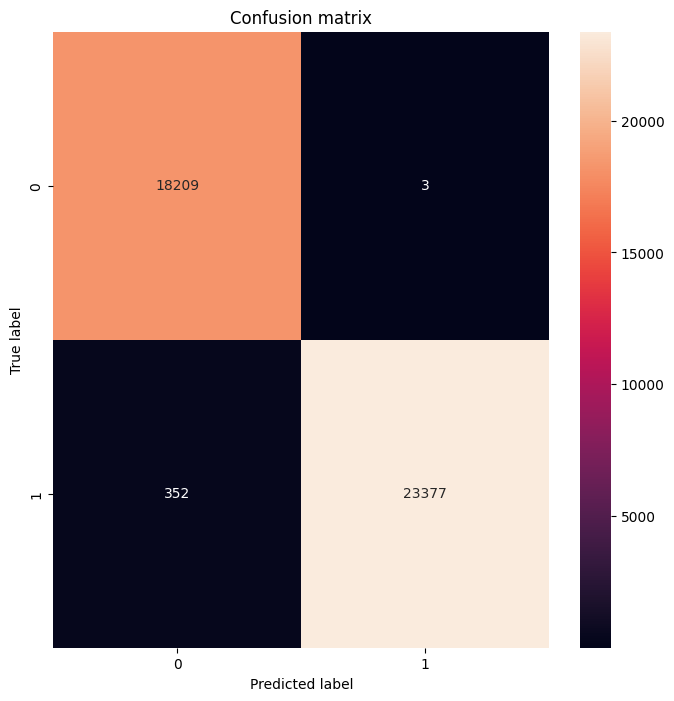

In [38]:
cf_matrix_plot(Y, y_pred, labels=[0,10])

In [ ]:
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score, precision_recall_curve

In [ ]:
target_names = {10: 'BENIGN', 0: 'PortScan'}

In [ ]:
logging.info("*** END ***")